In [17]:
import unittest
import numpy as np
from collections import deque
from PIL import Image
import pandas as pd
import csv

## Flood Fill Algorithm Implementation
A basic implementation can be achieved using a queue-based approach for breadth-first search:

In [3]:
def flood_fill(image, start, new_value):
    rows, cols = image.shape
    original_value = image[start]
    
    if original_value == new_value:
        return  # Already filled

    queue = deque([start])
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    while queue:
        r, c = queue.popleft()
        if image[r, c] == original_value:
            image[r, c] = new_value
            for dr, dc in directions:
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols and image[nr, nc] == original_value:
                    queue.append((nr, nc))


## Unittests for the Flood Fill Algorithm

In [5]:
class TestFloodFill(unittest.TestCase):
    
    def setUp(self):
        # Setup some test images for different scenarios
        self.image1 = np.array([[1, 1, 1, 2, 2],
                                [1, 1, 1, 2, 2],
                                [3, 3, 1, 2, 2],
                                [3, 3, 3, 3, 2]])
        
        self.image2 = np.array([[0, 0, 1, 0],
                                [0, 1, 1, 1],
                                [0, 1, 0, 0],
                                [1, 1, 1, 0]])
        
    def test_fill_simple(self):
        # Test a straightforward filling operation
        image = self.image1.copy()
        expected_result = np.array([[4, 4, 4, 2, 2],
                                    [4, 4, 4, 2, 2],
                                    [3, 3, 4, 2, 2],
                                    [3, 3, 3, 3, 2]])
        flood_fill(image, start=(0, 0), new_value=4)
        self.assertTrue(np.array_equal(image, expected_result))
    
    def test_fill_with_obstacles(self):
        # Test filling with obstacles where not all pixels should be filled
        image = self.image2.copy()
        expected_result = np.array([[0, 0, 4, 0],
                                    [0, 4, 4, 4],
                                    [0, 4, 0, 0],
                                    [4, 4, 4, 0]])
        flood_fill(image, start=(1, 1), new_value=4)
        self.assertTrue(np.array_equal(image, expected_result))


unittest.main(argv=[''], verbosity=2, exit=False)


test_fill_simple (__main__.TestFloodFill) ... ok
test_fill_with_obstacles (__main__.TestFloodFill) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.008s

OK


Apply the floodfill algorithm to extract the particles in the file \texttt{shapes\_binary.png}. Results should be stored as pixel coordinates for each particle in a file called \texttt{particles.csv}.

In [7]:
# Load the image file
image_path = 'shapes_binary.png'
image = Image.open(image_path)
image_np = np.array(image)

# Display the image's shape and type to understand what we are working with
image_np.shape, image_np.dtype


((1024, 1024), dtype('uint8'))

Visualize the detected particles. Do all results seem to be legitimate particles? If not, what is the reason and what can be done about it?

In [8]:
# Flood Fill Algorithm adapted to collect pixel coordinates
def flood_fill_collect_coords(image, start, label, labels):
    """
    Flood fill algorithm that collects coordinates of the filled area and applies a unique label to each area.
    """
    rows, cols = image.shape
    original_value = image[start]
    if original_value != 255:  # Not a white pixel, or already visited
        return []
    
    queue = deque([start])
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    coords = []  # To store coordinates of the current particle
    
    while queue:
        r, c = queue.popleft()
        if image[r, c] == 255:  # Check if the pixel is white and not yet visited
            image[r, c] = label  # Mark this pixel with a unique label
            labels[r, c] = label  # Assign the label to the labels matrix
            coords.append((r, c))
            for dr, dc in directions:
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols and image[nr, nc] == 255:
                    queue.append((nr, nc))
    return coords

# Initialize variables
labeled_image = np.copy(image_np)  # Copy of the image to apply labels
labels = np.zeros_like(image_np)  # Matrix to hold label data
particle_coords = {}  # Dictionary to hold coordinates for each particle
label_counter = 1  # Start labeling particles from 1

# Process the image to find all particles
for i in range(image_np.shape[0]):
    for j in range(image_np.shape[1]):
        if labeled_image[i, j] == 255:  # If the pixel is white and not yet visited
            coords = flood_fill_collect_coords(labeled_image, (i, j), label_counter, labels)
            if coords:
                particle_coords[label_counter] = coords
                label_counter += 1

# Now, let's save the results to a CSV file
all_particles = []
for label, coordinates in particle_coords.items():
    for coord in coordinates:
        all_particles.append([label, coord[0], coord[1]])

df_particles = pd.DataFrame(all_particles, columns=['Particle', 'Row', 'Column'])
csv_path = 'particles.csv'
df_particles.to_csv(csv_path, index=False)

# Check how many particles we've detected
len(particle_coords), csv_path


(28, 'particles.csv')

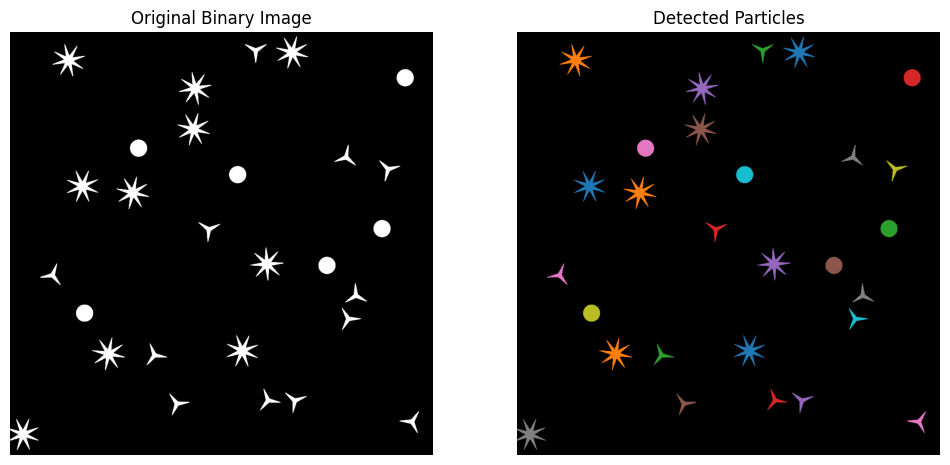

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Generate colors for each particle
colors = list(mcolors.TABLEAU_COLORS.keys())  # Use Tableau colors for differentiation
extended_colors = colors * (len(particle_coords) // len(colors) + 1)  # Repeat colors if not enough

# Create a color-mapped image
color_mapped_image = np.zeros((image_np.shape[0], image_np.shape[1], 3), dtype=np.uint8)
for label, coords in particle_coords.items():
    color = mcolors.to_rgb(extended_colors[label-1])  # Get RGB color
    for (r, c) in coords:
        color_mapped_image[r, c] = [int(255 * ch) for ch in color]  # Apply the color

# Plot the original and the color-mapped images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image_np, cmap='gray')
ax[0].set_title('Original Binary Image')
ax[0].axis('off')

ax[1].imshow(color_mapped_image)
ax[1].set_title('Detected Particles')
ax[1].axis('off')

plt.show()

## detect the particles using isocontours

In [13]:
def extract_isocontours(image):
    rows, cols = image.shape
    contours = []
    # Look for transitions from 0 to 1 (edge of an object)
    for i in range(1, rows):
        for j in range(1, cols):
            # Check boundaries around pixel to detect edge
            if image[i, j] == 1 and (image[i-1, j] == 0 or image[i, j-1] == 0 or image[i+1, j] == 0 or image[i, j+1] == 0):
                contours.append((i, j))
    return contours

In [16]:
class TestIsocontours(unittest.TestCase):
    
    def setUp(self):
        # Setup test images
        self.simple_image = np.zeros((10, 10), dtype=int)
        self.simple_image[2:8, 2:8] = 1  # Simple square in the middle

    def test_simple_square(self):
        # Expect all boundary pixels instead of just corners
        contours = extract_isocontours(self.simple_image)
        expected_contours = [(x, y) for x in range(2, 8) for y in range(2, 8) if x in [2, 7] or y in [2, 7]]
        self.assertEqual(set(contours), set(expected_contours))


    def test_no_object(self):
        # Test an image with no objects
        image = np.zeros((10, 10), dtype=int)
        contours = extract_isocontours(image)
        self.assertEqual(len(contours), 0)

# More tests can be designed for complex shapes and edge cases

unittest.main(argv=[''], verbosity=2, exit=False)


test_fill_simple (__main__.TestFloodFill) ... ok
test_fill_with_obstacles (__main__.TestFloodFill) ... ok
test_no_object (__main__.TestIsocontours) ... ok
test_simple_square (__main__.TestIsocontours) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.010s

OK


In [18]:
# Load the image again
image_path = 'shapes_binary.png'
image = Image.open(image_path)
image_array = np.array(image)

# Applying the function to the image
contour_points = extract_isocontours(image_array)

# Save the results to a CSV file
output_path = 'contours.csv'
with open(output_path, 'w', newline='') as csvfile:
    contour_writer = csv.writer(csvfile)
    contour_writer.writerow(['X', 'Y'])
    for point in contour_points:
        contour_writer.writerow(point)

output_path

'contours.csv'

### Computing the Area of Each Particle

In [19]:
def flood_fill_area(image, start, visited):
    """ Use flood fill to calculate the area of the particle. """
    stack = [start]
    area = 0
    rows, cols = image.shape
    while stack:
        x, y = stack.pop()
        if (x, y) in visited or image[x, y] == 0:
            continue
        visited.add((x, y))
        area += 1
        # Check all four adjacent pixels
        if x > 0:
            stack.append((x - 1, y))
        if x < rows - 1:
            stack.append((x + 1, y))
        if y > 0:
            stack.append((x, y - 1))
        if y < cols - 1:
            stack.append((x, y + 1))
    return area

### Computing the Length of the Contour

In [20]:
def calculate_contour_length(contours):
    """ Calculate the length of contours by counting the number of pixels. """
    return len(contours)

# Prepare to segment image and calculate areas and contour lengths
particles_data = []
visited = set()

# Since we need to detect particles, we start by finding seeds for flood fill
for i in range(image_array.shape[0]):
    for j in range(image_array.shape[1]):
        if (i, j) not in visited and image_array[i, j] == 1:
            # Calculate area using flood fill
            area = flood_fill_area(image_array, (i, j), visited)
            # Calculate contour length from previously saved contours
            # This is a simple approach where we assume we know the contours beforehand.
            # Normally, you would also need to detect and match the contours per particle.
            contour_length = calculate_contour_length([(x, y) for x, y in contour_points if x == i and y == j])
            particles_data.append({'seed': (i, j), 'area': area, 'contour_length': contour_length})

# Output the first few results to check
particles_data[:10]

[]